In [1]:
import sys
sys.path.insert(1, '../')


In [2]:
import importlib
import medical_explainer
importlib.reload(medical_explainer)


<module 'medical_explainer' from '/Users/ahsueh/Documents/GA Tech/BD4H/Uni-ACS/mimiciv_sepsis_mortality/../medical_explainer.py'>

In [3]:
import pandas as pd
data = pd.read_csv('mimiciv_sepsis.csv').drop(['testtrain', 'hadm_id'], axis=1)

data['gender'] = data['gender'].apply(lambda x: 1 if x == 'M' else 0)

data = pd.concat([data, pd.get_dummies(data['marital_status'], prefix='marital_status')], axis=1)
data = data.drop(['marital_status'], axis=1)

data = pd.concat([data, pd.get_dummies(data['ethnicity'], prefix='ethnicity')], axis=1)
data = data.drop(['ethnicity'], axis=1)

data = pd.concat([data, pd.get_dummies(data['insurance'], prefix='insurance')], axis=1)
data = data.drop(['insurance'], axis=1)

data = pd.concat([data, pd.get_dummies(data['ed_medgp_antibiotic_hrgp'], prefix='antibiotic')], axis=1)
data = data.drop(['ed_medgp_antibiotic_hrgp'], axis=1)

In [4]:
from sklearn.model_selection import train_test_split

seed = 7

X = data.drop(['icu_adm_flag', 'hosdeath_flag'], axis=1)
y = data['hosdeath_flag']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=seed)


In [5]:
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
imp = IterativeImputer(max_iter=10, random_state=0)
imp.fit(X_train)

X_train = pd.DataFrame(imp.transform(X_train), columns=X.columns)
X_test = pd.DataFrame(imp.transform(X_test), columns=X.columns)

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve

# Random Forest
clf = RandomForestClassifier(n_estimators=200, max_depth=5, random_state=seed)
clf.fit(X_train, y_train)

# # Gradient Boosting
# clf = GradientBoostingClassifier(n_estimators=100, max_depth=5, min_samples_split=2,
#                                  min_samples_leaf=1, criterion='friedman_mse', random_state=seed).fit(X_train, y_train)

# # Neural Network
# from sklearn.pipeline import Pipeline
# from sklearn.preprocessing import StandardScaler
# from sklearn.neural_network import MLPClassifier
# estimators = [('Scaler', StandardScaler()), 
#               ('Neural_Network', MLPClassifier(
#                   hidden_layer_sizes=(100),
#                   random_state=seed, 
#                   activation='logistic', 
#                   solver='sgd', 
#                   max_iter=1000))]
# pipe = Pipeline(estimators)
# pipe.fit(X_train, y_train)


ROC AUC: 0.9005984298622427
Average Precision: 0.45213201863353625
Accuracy: 0.9319462505418292


In [20]:
roc_curve_orig = roc_curve(y_test, clf.predict_proba(X_test)[:, 1])

| Step 1  ==> Calibrating model


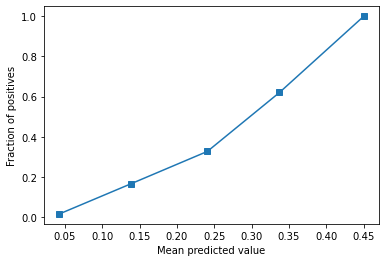

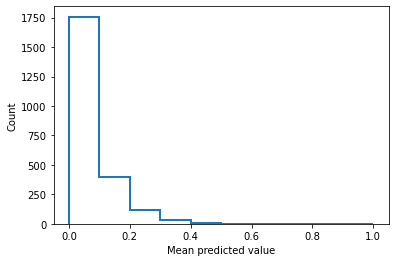

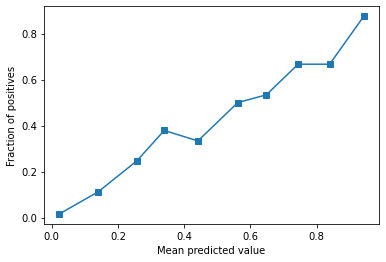

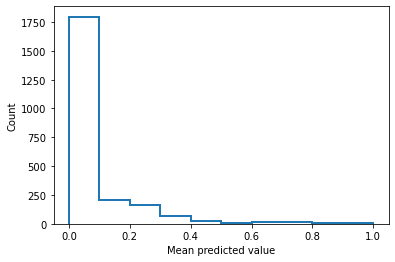

ROC AUC: 0.9005984298622427
Average Precision: 0.45213201863353625
Accuracy: 0.9319462505418292
ROC AUC: 0.9019167530736186
Average Precision: 0.4387164397832944
Accuracy: 0.9371478110099697

| Step 2 ==> Calculate SHAP values

| Step 3 ==> Fit clinical score calculator
Novel fitting


Probability threshold: 0.1
Score threshold: 32.0

Probability threshold: 0.5
Score threshold: 84.0

Probability threshold: 0.9
Score threshold: 84.0



In [8]:
# Run Uni-ACS explainer
explainer = medical_explainer.explainer(
    clf, X_train, y_train, X_test, y_test)

# GBoost, RF
explainer.fit(10, shap_method='tree', method='novel', calculator_threshold=0.0001)

# Neural Network
# explainer.fit(10, shap_method='kernel', method='novel', n_splits=2)

In [15]:
scores,probs,predictions = explainer.predict_calculator(X_test, 1)

In [16]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

roc_auc = roc_auc_score(y_test, probs)
print("ROC AUC: " + str(roc_auc))

average_precision = average_precision_score(y_test, probs)
print("Average Precision: " + str(average_precision))

# accuracy = accuracy_score(y_test, predictions)
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: " + str(accuracy))

# print(confusion_matrix(y_test, predictions))
print(confusion_matrix(y_test, predictions))


ROC AUC: 0.8597230039994076
Average Precision: 0.3235341262666235
Accuracy: 0.9332466406588643
[[2149    1]
 [ 153    4]]


In [21]:
roc_curve_learner = roc_curve(y_test, probs)

In [25]:
import matplotlib.pyplot as plt

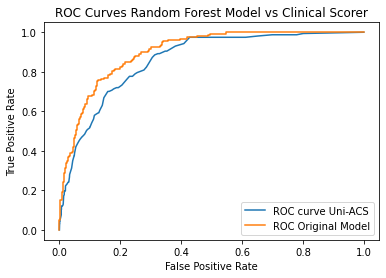

In [31]:
plt.plot(roc_curve_learner[0], roc_curve_learner[1], label="ROC curve Uni-ACS")
plt.plot(roc_curve_orig[0], roc_curve_orig[1], label="ROC Original Model")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves Random Forest Model vs Clinical Scorer")
plt.legend(loc="lower right")

plt.savefig('RF_roc.png')
